<a href="https://colab.research.google.com/github/cnytblci/UTS_ML2019_Main/blob/master/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

from google.colab import drive 
drive.mount('/content/drive')

In [0]:
df=pd.read_csv('/content/drive/My Drive/athlete_events.csv')
df.iloc[0:10]

In [0]:
# Clear Distribution graph shown here

import matplotlib.pyplot as plt

ax = df['Age'].hist(bins=15, density=True, stacked=True, color='blue', alpha=0.6)
df['Age'].plot(kind='density', color='red')
ax.set(xlabel='Age')
plt.xlim(0,160)
plt.show()

ax = df['Height'].hist(bins=17, density=True, stacked=True, color='blue', alpha=0.6)
df['Height'].plot(kind='density', color='red')
ax.set(xlabel='Height')
plt.xlim(100,270)
plt.show()

ax = df['Weight'].hist(bins=17, density=True, stacked=True, color='blue', alpha=0.6)
df['Weight'].plot(kind='density', color='red')
ax.set(xlabel='Weight')
plt.xlim(0,370)
plt.show()

In [0]:
df.isnull().sum()

In [0]:
#HANDLING WITH MISSING VALUES
import statistics
# fiter dataframe to select rows where Height is not Null, then only select the Height column from the result
z = df[df.Height.notnull()]['Height']
# find the average of the resulting height column
h_avg = np.average(z)
# the orignal height column is equal to the orignal height column with nan replaced with the average
df['Height'] = df['Height'].fillna(h_avg)

# Since age is right skewed, null values are replaced with median
df['Age'] = df['Age'].fillna(statistics.median(df['Age']))

# same as above but with Weight
w_avg = np.average(df[df.Weight.notnull()]['Weight'])
df['Weight'] = df['Weight'].fillna(w_avg)

#fill null medal values with 'not awarded' 
df['Medal']=df['Medal'].fillna('Not awarded')

df.isnull().sum()


In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

#Height normalization
h=df[['Height']].values.astype(float)
h_scaled = min_max_scaler.fit_transform(h)
h_normalized = pd.DataFrame(h_scaled)

df['Normalized_Height'] = h_normalized
df = df.drop(['Height'],axis=1)


In [0]:
print(df['Age'].describe())

#Boxplot of Weight
df.boxplot(column=['Weight'],figsize=(8,6))

In [0]:
#Age dicretization
a_bin = pd.cut(np.array(df['Age']), 7,labels=["age1","age2","age3","age4","age5","age6","age7"])
print(a_bin)

a_list=df['Age'].values.tolist()
print(a_list)

df['new_age'] = a_bin
df = df.drop(['Age'],axis=1)


In [0]:
df.head(10)

In [0]:
from sklearn.preprocessing import LabelEncoder

lb_encode = LabelEncoder()
df['Sex_Code'] = lb_encode.fit_transform(df['Sex'])
df['Sport_Code'] = lb_encode.fit_transform(df['Sport'])
df['Event_Code'] = lb_encode.fit_transform(df['Event'])
df['Medal_Code'] = lb_encode.fit_transform(df['Medal'])
df['Age_Code'] = lb_encode.fit_transform(df['new_age'])
df.head()

In [0]:
# Correlation Matrix 

rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [0]:
#Remove columns that has no corrletion with Weight attributes & Remove old columns

df = df.drop(['ID','Sex','Sport','Event','Medal','me', 'Team', 'Season', 'Year', 'NOC', 'Games', 'City','new_age'], axis=1)
df.iloc[0:10]


In [0]:
# Splitting the dataset into training and testing

x = df.loc[:, df.columns != 'Weight']
y = df.loc[:, df.columns == 'Weight']


from sklearn.model_selection import train_test_split

XTrain, XTest, YTrain, YTest = train_test_split(x , y, test_size = 0.3, random_state = 0)


In [0]:
#Average value of the Weight of the athletes

import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

plt.figure(figsize=(8,6))
plt.tight_layout()
seabornInstance.distplot(df['Weight'])

In [0]:
#LINEAR REGRESSION(LR) MODEL
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lr = LinearRegression(fit_intercept= True, normalize=True, n_jobs=1)
lr.fit(XTrain, YTrain)
y_prediction= lr.predict(XTest)

print('Intercept=',lr.intercept_)
print('Slope=', lr.coef_)

In [0]:
#LR: Predicted vs Actual Weight

df_Prediction = pd.DataFrame(y_prediction) 
df_Prediction.rename(columns={0:'Predicted (Linear Regression)'}, inplace=True)

df_Prediction.reset_index(drop=True, inplace=True)
YTest.reset_index(drop=True, inplace=True)

df_lr_comparison=pd.concat([df_Prediction, YTest], axis=1)
df_lr_comparison

In [0]:
#LR: Coefficiency of the model

coef = lr.coef_ .flatten() 
df_coef= pd.DataFrame(coef)
df_coef.rename(columns={0:'Coefficient'}, inplace=True)

df_xColumns= pd.DataFrame(XTest.columns)
df_xColumns.rename(columns={0:'Attributes'}, inplace=True)

df_acoef=pd.concat([df_coef, df_xColumns], axis=1)
df_acoef

In [0]:
#LR: R2 score
from sklearn.metrics import r2_score

y_lrprediction = lr.predict(XTest)
lr_score = r2_score(YTest,y_lrprediction, multioutput='variance_weighted')
print('Coefficient of determination=',lr_score)

#LR Variance Score 
from sklearn.metrics import explained_variance_score

print('Varince Score is ',explained_variance_score(YTest, y_lrprediction,multioutput='variance_weighted'))

#Performance evaluation- MAE,MSE,RMSE
from sklearn import metrics

print('Mean Absolute Error (MAE)=', metrics.mean_absolute_error(YTest, y_lrprediction))  
print('Mean Squared Error(MSE)=', metrics.mean_squared_error(YTest, y_lrprediction))  
print('Root Mean Squared Error (RMSE)=', np.sqrt(metrics.mean_squared_error(YTest, y_lrprediction)))


In [0]:
#Linear Regression Predicted vs Expected Scatter Plot

plt.title ('Predicted VS Expected')
plt.xlabel('Expected')
plt.ylabel('Predicted')
plt.scatter(YTest, y_prediction) 


In [0]:
#LassoCV Regression Model

from sklearn.linear_model import LassoCV

#R2 Score Lasso
lasso = LassoCV(cv=5, random_state=np.random)
lasso.fit(XTrain, YTrain)
lasso_p=lasso.predict(XTest)
lasso_score=r2_score(YTest,lasso_p,multioutput='variance_weighted')
print('Coefficient of determination=',lasso_score)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Coefficient of determination= 0.6288548780143


In [0]:
lasso_coef = lasso.coef_ .flatten() 
df_lasso_coef= pd.DataFrame(lasso_coef)
df_lasso_coef.rename(columns={0:'Coefficient'}, inplace=True)

df_xColumns= pd.DataFrame(XTest.columns)
df_xColumns.rename(columns={0:'Attributes'}, inplace=True)

df_Lcoef=pd.concat([df_lasso_coef, df_xColumns], axis=1)
df_Lcoef

,Coefficient,Attributes
0,81.234858,Normalized_Height
1,4.456506,Sex_Code
2,0.210709,Sport_Code
3,-0.016137,Event_Code
4,-0.000000,Medal_Code
5,0.779042,Age_Code


In [0]:
#Ridge Model
from sklearn.linear_model import Ridge

r = Ridge(alpha=0.05, normalize=True)

r.fit(XTrain,YTrain)

r_pre = r.predict(XTest)

print('r2 scor: ', r2_score(YTest,r_pre))

r2 scor:  0.6374944141058996


In [0]:
r_coef = r.coef_ .flatten() 
df_r_coef= pd.DataFrame(r_coef)
df_r_coef.rename(columns={0:'Coefficient'}, inplace=True)

df_xColumns= pd.DataFrame(XTest.columns)
df_xColumns.rename(columns={0:'Attributes'}, inplace=True)

df_Rcoef=pd.concat([df_r_coef, df_xColumns], axis=1)
df_Rcoef

,Coefficient,Attributes
0,91.055946,Normalized_Height
1,4.113731,Sex_Code
2,0.046074,Sport_Code
3,-0.001023,Event_Code
4,-0.212247,Medal_Code
5,0.981736,Age_Code


In [0]:
#Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor( min_samples_leaf=7, min_samples_split=30,max_depth=23,criterion ='friedman_mse', random_state = np.random,) 
regressor.fit(XTrain, YTrain)


# DT Predicting an Attribute "Weight"
from sklearn.metrics import r2_score


y_pred = regressor.predict(XTest)
score = r2_score(YTest,y_pred)
print('Coefficient of determination=',score)

print('Varince Score is ',explained_variance_score(YTest, y_pred,multioutput='variance_weighted'))
print('Mean Absolute Error (MAE)=', metrics.mean_absolute_error(YTest, y_pred))  
print('Mean Squared Error(MSE)=', metrics.mean_squared_error(YTest, y_pred))  
print('Root Mean Squared Error (RMSE)=', np.sqrt(metrics.mean_squared_error(YTest, y_pred)))


In [0]:
#DT Predicted vs Actual Weight

df_DTPrediction = pd.DataFrame(y_pred) 
df_DTPrediction.rename(columns={0:'Predicted(Decision Tree)'}, inplace=True)

df_DTPrediction.reset_index(drop=True, inplace=True)
YTest.reset_index(drop=True, inplace=True)

df_dt_comparison=pd.concat([df_DTPrediction, YTest], axis=1)
df_dt_comparison



In [0]:
#DT Scatter Plot Predicted vs Actual
plt.title ('Predicted VS Expected (Decision Tree Model)')
plt.xlabel('Expected')
plt.ylabel('Predicted')
plt.scatter(YTest, y_pred,c='b') 

In [0]:

import math
from sklearn.neighbors import kneighbors_graph
from sklearn import neighbors

for k in range(13):
    k = k+1
    kn = neighbors.KNeighborsRegressor(n_neighbors = k,weights= 'distance', )

kn.fit(XTrain, YTrain)  
kn_pr=kn.predict(XTest)
mse = math.sqrt(metrics.mean_squared_error(YTest,kn_pr)) 

print('RMSE value of K= ', mse)
# DT Predicting an Attribute "Weight"
from sklearn.metrics import r2_score
kn_score = r2_score(YTest,kn_pr)
print('Coefficient of determination=',kn_score)

print('Varince Score is ',explained_variance_score(YTest, kn_pr,multioutput='variance_weighted'))
print('Mean Absolute Error (MAE)=', metrics.mean_absolute_error(YTest, kn_pr))  
print('Mean Squared Error(MSE)=', metrics.mean_squared_error(YTest, kn_pr))  
print('Root Mean Squared Error (RMSE)=', np.sqrt(metrics.mean_squared_error(YTest, kn_pr)))

RMSE value of K=  5.589448001585552
Coefficient of determination= 0.8039595714073426
Varince Score is  0.8039644578087206
Mean Absolute Error (MAE)= 3.5129717072614737
Mean Squared Error(MSE)= 31.241928962428727
Root Mean Squared Error (RMSE)= 5.589448001585552


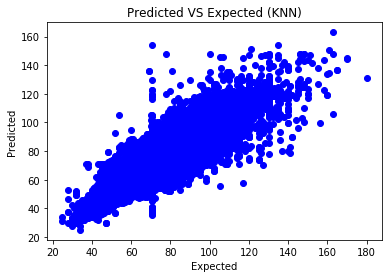

In [44]:
#KNN Scatter plot

plt.title ('Predicted VS Expected (KNN)')
plt.xlabel('Expected')
plt.ylabel('Predicted')
plt.scatter(YTest, kn_pr, c='b') 